## Dependencies

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, AvgPool2D, Add, Dense 
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import Model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


## Data Augmentaion

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 150,150

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator( rescale = 1./255. )

train_generator = train_datagen.flow_from_directory(
                    "../input/intel-image-classification/seg_train/seg_train/",
                    batch_size=128,
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)     

test_generator =  test_datagen.flow_from_directory(
                    "../input/intel-image-classification/seg_test/seg_test/",
                    batch_size=128, 
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [3]:
img_shape = (150, 150, 3)

# Model Building

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate
from keras.layers import Dropout

## Inception Module

In [5]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [6]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

   
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)
    X = X_input
    
    # Stage 1
    X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)

    # Stage 2
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)

    
    # Stage 3
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
    X = Activation('relu')(X)
       

    # inception module (out 128)
    X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
    X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
    X = Activation('relu')(X)    
    
    # inception module (out 256)
    X = inception_module(X, f1=64, f2_in=(64+16), f2_out=128, f3_in=16, f3_out=32, f4_out=32)
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=5, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv7')(X)
    X = Activation('relu')(X)
    
    # inception module (out 512)
    X = inception_module(X, f1=128, f2_in=(128+32), f2_out=256, f3_in=32, f3_out=64, f4_out=64)
    X = BatchNormalization(axis = 3, name = 'bn_conv8')(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 1024], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 1024], stage=6, block='b')
    X = BatchNormalization(axis = 3, name = 'bn_conv9')(X)
    X = Activation('relu')(X)    



    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    #X = Dropout(0.25)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

    return model

In [9]:
img_shape = (150, 150, 3)
model = DeepResNetInception(input_shape=img_shape, classes=6)

In [10]:
model.summary()

Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 74, 74, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 74, 74, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 16)   0           bn_conv1[0][0]                   
____________________________________________________________________________________

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
#model.load_weights('../input/deep-res-ception-v8_weights/Deep-Res-ception-v8_weights.h5')

fitting the model with real-time **data augmentation**:


In [13]:
trained_model = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=50
)

Epoch 1/50
110/110 [==============================] - 116s 1s/step - loss: 1.3104 - accuracy: 0.4886 - val_loss: 2.5269 - val_accuracy: 0.1843
Epoch 2/50
110/110 [==============================] - 82s 745ms/step - loss: 0.9543 - accuracy: 0.6341 - val_loss: 2.5462 - val_accuracy: 0.1850
Epoch 3/50
110/110 [==============================] - 85s 770ms/step - loss: 0.8645 - accuracy: 0.6729 - val_loss: 1.7497 - val_accuracy: 0.4117
Epoch 4/50
110/110 [==============================] - 84s 767ms/step - loss: 0.7896 - accuracy: 0.7004 - val_loss: 0.9662 - val_accuracy: 0.5663
Epoch 5/50
110/110 [==============================] - 85s 774ms/step - loss: 0.7420 - accuracy: 0.7248 - val_loss: 1.2123 - val_accuracy: 0.6357
Epoch 6/50
110/110 [==============================] - 85s 769ms/step - loss: 0.6997 - accuracy: 0.7422 - val_loss: 0.9316 - val_accuracy: 0.7277
Epoch 7/50
110/110 [==============================] - 85s 776ms/step - loss: 0.6675 - accuracy: 0.7564 - val_loss: 0.8425 - val_accu

/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


110/110 [==============================] - 115s 1s/step - loss: 0.3908 - accuracy: 0.8544 - val_loss: 0.2813 - val_accuracy: 0.8087
Epoch 27/50
110/110 [==============================] - 85s 775ms/step - loss: 0.3996 - accuracy: 0.8529 - val_loss: 2.2842 - val_accuracy: 0.4807
Epoch 28/50
110/110 [==============================] - 86s 779ms/step - loss: 0.3933 - accuracy: 0.8556 - val_loss: 0.4426 - val_accuracy: 0.7437
Epoch 29/50
110/110 [==============================] - 86s 778ms/step - loss: 0.3790 - accuracy: 0.8597 - val_loss: 0.8338 - val_accuracy: 0.7637
Epoch 30/50
110/110 [==============================] - 86s 783ms/step - loss: 0.3800 - accuracy: 0.8613 - val_loss: 0.3101 - val_accuracy: 0.8413
Epoch 31/50
110/110 [==============================] - 86s 783ms/step - loss: 0.3660 - accuracy: 0.8677 - val_loss: 0.8800 - val_accuracy: 0.7173
Epoch 32/50
110/110 [==============================] - 86s 786ms/step - loss: 0.3750 - accuracy: 0.8647 - val_loss: 0.6503 - val_accuracy:

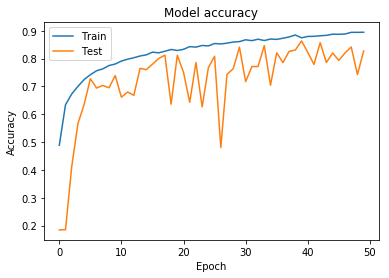

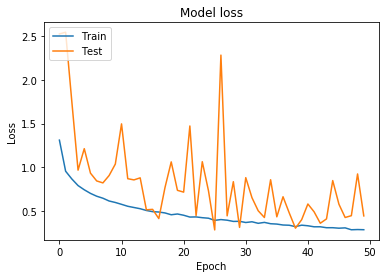

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
model.evaluate_generator(test_generator)

[0.4419097900390625, 0.8276666402816772]

In [16]:
model.save_weights('Deep-Res-ception_with_da_weights.h5')